In [1]:
import numpy as np
import pandas as pd
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
from keras.initializers import glorot_uniform

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [2]:
def identity_block(X, f, filters, stage, block):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [3]:
def convolutional_block(X, f, filters, stage, block, s=2):

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [4]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model


In [5]:
model = ResNet50( classes = 7)#input_shape = (64, 64, 3)

In [6]:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer= sgd, loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
meta_df =pd.read_csv("modified_meta.csv")

In [9]:
meta_df = meta_df.drop(meta_df[meta_df.cell_type_idx==4].iloc[:4000].index)
meta_df['cell_type_idx'].value_counts()

4    2705
5    1113
2    1099
1     514
0     327
6     142
3     115
Name: cell_type_idx, dtype: int64

In [10]:
meta_df['image'] = meta_df['path'].map(lambda x: np.asanyarray(Image.open(x).resize((64,64))))

In [11]:
data_aug_rate = [7,5,2,12,0,3,12]  ##16k

for i in range(7):
    if data_aug_rate[i]:
        meta_df=meta_df.append([meta_df.loc[meta_df['cell_type_idx'] == i,:]]*(data_aug_rate[i]-1), ignore_index=True)
print(len(meta_df))
meta_df['cell_type'].value_counts()

16185


Melanoma                3339
Melanocytic nevi        2705
Basal cell carcinoma    2570
Actinic keratoses       2289
Benign keratosis        2198
Vascular lesions        1704
Dermatofibroma          1380
Name: cell_type, dtype: int64

In [12]:
class_names = [
    'Actinic keratose',
    'Basal cell carcinoma',
    'Benign keratosis',
    'Dermatofibroma ',
    'Melanocytic nevi',
    'Melanoma',
    'Vascular lesions'
]

In [13]:
df_val,df_train = train_test_split(meta_df, test_size=0.8)

In [14]:
df_val['cell_type_idx'].value_counts()

5    656
4    522
1    510
0    465
2    437
6    370
3    277
Name: cell_type_idx, dtype: int64

In [15]:
len(df_val)

3237

In [16]:
df_val, df_test = train_test_split(df_val, test_size=0.5)
df_train = df_train.reset_index()

df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [17]:
len(df_test)

1619

In [18]:
y_train_o = df_train.cell_type_idx
x_train_o = df_train.drop(['cell_type_idx'],axis=1)

y_test_o = df_test.cell_type_idx
x_test_o = df_test.drop(['cell_type_idx'],axis=1)

y_val_o = df_val.cell_type_idx
x_val_o = df_val.drop(['cell_type_idx'],axis=1)

x_test_o.head(3)

,index,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,duplicates,image
0,10947,HAM_0005903,ISIC_0032179,bkl,consensus,65.0,male,upper extremity,data\HAM10000_images_part_2\ISIC_0032179.jpg,Benign keratosis,unduplicated,"[[[198, 158, 158], [195, 158, 150], [196, 155,..."
1,15422,HAM_0002390,ISIC_0029439,vasc,consensus,50.0,male,abdomen,data\HAM10000_images_part_2\ISIC_0029439.jpg,Vascular lesions,unduplicated,"[[[219, 177, 178], [219, 175, 174], [220, 170,..."
2,7375,HAM_0000967,ISIC_0025539,akiec,histo,75.0,male,lower extremity,data\HAM10000_images_part_1\ISIC_0025539.jpg,Actinic keratoses,unduplicated,"[[[213, 182, 179], [212, 176, 176], [215, 184,..."


In [19]:
x_train = np.asarray(x_train_o['image']).tolist()
x_test = np.asarray(x_test_o['image']).tolist()
x_val = np.asarray(x_val_o['image']).tolist()

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_val_mean = np.mean(x_val)
x_val_std = np.std(x_val)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std
x_val = (x_val - x_val_mean)/x_val_std


y_train = to_categorical(y_train_o,num_classes=7)
y_test = to_categorical(y_test_o,num_classes=7)
y_val = to_categorical(y_val_o,num_classes=7)

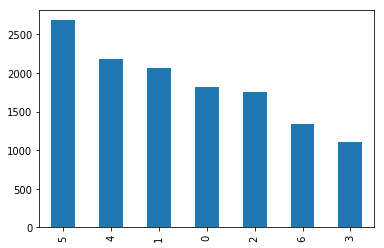

In [20]:
y_train_o.value_counts().plot(kind='bar')

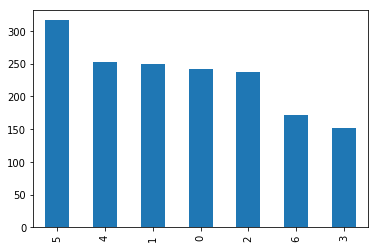

In [21]:
y_test_o.value_counts().plot(kind='bar')

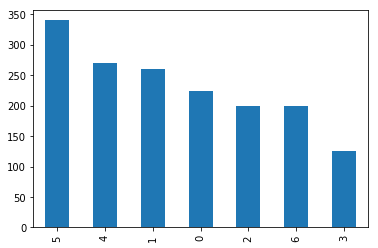

In [22]:
y_val_o.value_counts().plot(kind='bar')

In [23]:
augm = ImageDataGenerator(
featurewise_center=True,
#featurewise_std_normalization=True,
rotation_range=30,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=True,
vertical_flip=True)

augm.fit(x_train)

In [24]:
model.load_weights("skin_cancer_git.h5")
print("Loaded model from disk")

Loaded model from disk


In [25]:
batch_size  = 64
epochs = 5

history = model.fit(x_train,y_train,batch_size=batch_size,epochs =epochs,validation_data = (x_val,y_val),verbose =1)

Train on 12948 samples, validate on 1618 samples
Epoch 1/5
12948/12948 [==============================] - 209s 16ms/step - loss: 0.6081 - acc: 0.7705 - val_loss: 0.5638 - val_acc: 0.7794
Epoch 2/5
12948/12948 [==============================] - 195s 15ms/step - loss: 0.5180 - acc: 0.8078 - val_loss: 0.4576 - val_acc: 0.8387
Epoch 3/5
12948/12948 [==============================] - 194s 15ms/step - loss: 0.3985 - acc: 0.8530 - val_loss: 0.4403 - val_acc: 0.8325
Epoch 4/5
12948/12948 [==============================] - 195s 15ms/step - loss: 0.3334 - acc: 0.8753 - val_loss: 0.4346 - val_acc: 0.8480
Epoch 5/5
12948/12948 [==============================] - 195s 15ms/step - loss: 0.2683 - acc: 0.9026 - val_loss: 0.4105 - val_acc: 0.8603


In [26]:
evaluation = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss:', evaluation[0])
print('Test Accuracy:', evaluation[1])

Test Loss: 0.5648114031446503
Test Accuracy: 0.8116121063120502


In [27]:
model_json = model.to_json()
with open("model_64.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights('skin_cancer_git.h5')

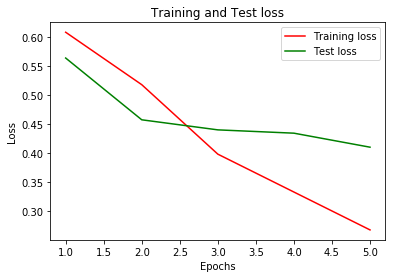

In [28]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss',)
plt.plot(epochs, val_loss, color='green', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

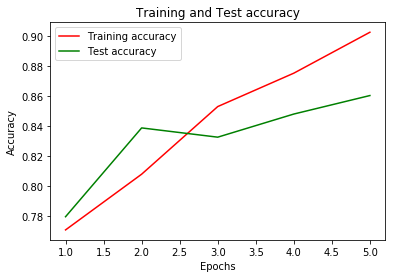

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, color='red', label='Training accuracy')
plt.plot(epochs, val_acc, color='green', label='Test accuracy')
plt.title('Training and Test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    
    y_pred = y_pred.argmax(axis=1)
    y_true = y_true.argmax(axis=1)
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[215   8   2   0  10   5   1]
 [  3 226   6   3   9   1   2]
 [  6  13 128   5  68  16   1]
 [  0   1   1 149   0   1   0]
 [  2  16   8   1 202  20   3]
 [  1   1   7   0  81 225   1]
 [  0   1   0   0   1   0 169]]


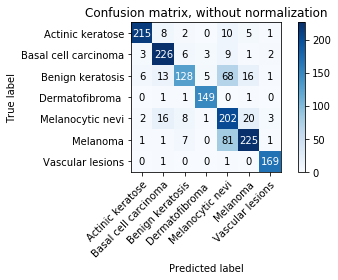

In [31]:
y_pred = model.predict(x_test)

plot_confusion_matrix(y_test, y_pred, classes=class_names)